# 02_exercise.ipynb: Protein Engineering with ESM-2 and ESMFold

#### Instructions:

1. Run ESMFold to predict the structure and the confidence metrics (average pLDDT) for a protein sequence of your choice.
2. Mask part of the sequence and generate mutants using ESM-2.
3. Run ESMFold again with the mutant sequence and compare the confidence metrics with the wild type metrics.

*Objective*: Find candidate mutants with higher confidence metrics (average pLDDT).

#### Tips:

- click the little ▶ play icon to the left of each cell below

*PS*: Implementation based on the [ESMFold Colab implementation](https://github.com/facebookresearch/esm/tree/main/esm).

In [76]:
%%time
#@title Install ESM-2 and ESMFold + Download Model Weights
#@markdown Install ESM-2 and ESMFold + Download Model Weights (~5min)
version = "1"
model_name = "esmfold_v0.model" if version == "0" else "esmfold.model"
import os, time
if not os.path.isfile(model_name):
  # download esmfold params
  os.system("apt-get install aria2 -qq")
  os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/{model_name} &")

  if not os.path.isfile("finished_install"):
    # install libs
    print("installing libs...")
    os.system("pip install -q omegaconf pytorch_lightning biopython ml_collections einops py3Dmol modelcif")
    os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")

    print("installing openfold...")
    # install openfold
    os.system(f"pip install -q git+https://github.com/sokrypton/openfold.git")

    print("installing esmfold...")
    # install esmfold
    os.system(f"pip install -q git+https://github.com/sokrypton/esm.git")
    os.system("touch finished_install")

  # wait for Params to finish downloading...
  while not os.path.isfile(model_name):
    time.sleep(5)
  if os.path.isfile(f"{model_name}.aria2"):
    print("downloading params...")
  while os.path.isfile(f"{model_name}.aria2"):
    time.sleep(5)

import torch
import esm
import random

# Load ESM-2 model
esm2_model, esm2_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = esm2_alphabet.get_batch_converter()
esm2_model.eval()  # disables dropout for deterministic results


CPU times: user 9.21 s, sys: 2.61 s, total: 11.8 s
Wall time: 20 s


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

After this installation, the ESM-2 model is installed at the esm2_model variable.

## Choose your protein sequence for optimization in the next cell

In [77]:
wild_type_sequence = "GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE"

# Copy one of the sequences below as the to the wild_type_sequence variable:
# Sequence 1: Synthetic Protein (Average pLDDT: 90.251)
# synthetic_sequence = "GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE"
# Sequence 2: Ubiquitin (Average pLDDT: 90.474)
# ubiquitin_sequence = "MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG"
# Sequence 3: Cystatin C (Average pLDDT: 88.821)
# cystatin_sequence = "GPMDASVEEEGVRRALDFAVGEYNKASNDMYHSRALQVVRARKQIVAGVNYFLDVELGRTTCTKTQPNLDNCPFHDQPHLKRKAFCSFQIYAVPWQGTMTLSKSTCQDA"

# Predict the structure of the protein sequence and plot the confidence metrics of the prediction.

In [78]:
#@title ##Run **ESMFold** Prediction (~1min)
%%time
from string import ascii_uppercase, ascii_lowercase
import hashlib, re, os
import numpy as np
import torch
from jax.tree_util import tree_map
import matplotlib.pyplot as plt
from scipy.special import softmax
import gc

def parse_output(output):
  pae = (output["aligned_confidence_probs"][0] * np.arange(64)).mean(-1) * 31
  plddt = output["plddt"][0,:,1]

  bins = np.append(0,np.linspace(2.3125,21.6875,63))
  sm_contacts = softmax(output["distogram_logits"],-1)[0]
  sm_contacts = sm_contacts[...,bins<8].sum(-1)
  xyz = output["positions"][-1,0,:,1]
  mask = output["atom37_atom_exists"][0,:,1] == 1
  o = {"pae":pae[mask,:][:,mask],
       "plddt":plddt[mask],
       "sm_contacts":sm_contacts[mask,:][:,mask],
       "xyz":xyz[mask]}
  return o

def get_hash(x): return hashlib.sha1(x.encode()).hexdigest()
alphabet_list = list(ascii_uppercase+ascii_lowercase)

jobname = "wild_type_protein" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = wild_type_sequence
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 3
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name, weights_only=False)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 68
ptm: 0.817 plddt: 90.521
CPU times: user 1.88 s, sys: 17.2 ms, total: 1.9 s
Wall time: 1.89 s


In [79]:
#@title Display Wild Type Protein
import py3Dmol
pymol_color_list = ["#33ff33","#00ffff","#ff33cc","#ffff00","#ff9999","#e5e5e5","#7f7fff","#ff7f00",
                    "#7fff7f","#199999","#ff007f","#ffdd5e","#8c3f99","#b2b2b2","#007fff","#c4b200",
                    "#8cb266","#00bfbf","#b27f7f","#fcd1a5","#ff7f7f","#ffbfdd","#7fffff","#ffff7f",
                    "#00ff7f","#337fcc","#d8337f","#bfff3f","#ff7fff","#d8d8ff","#3fffbf","#b78c4c",
                    "#339933","#66b2b2","#ba8c84","#84bf00","#b24c66","#7f7f7f","#3f3fa5","#a5512b"]

def show_pdb(pdb_str, show_sidechains=False, show_mainchains=False,
             color="pLDDT", chains=None, vmin=50, vmax=90,
             size=(800,480), hbondCutoff=4.0,
             Ls=None,
             animate=False):

  if chains is None:
    chains = 1 if Ls is None else len(Ls)
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js', width=size[0], height=size[1])
  if animate:
    view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  else:
    view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  if color == "pLDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':vmin,'max':vmax}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})
  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                  {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                  {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  view.zoomTo()
  if animate: view.animate()
  return view

color = "confidence"
if color == "confidence": color = "pLDDT"
show_sidechains = False
show_mainchains = False
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Average pLDDT: 90.52


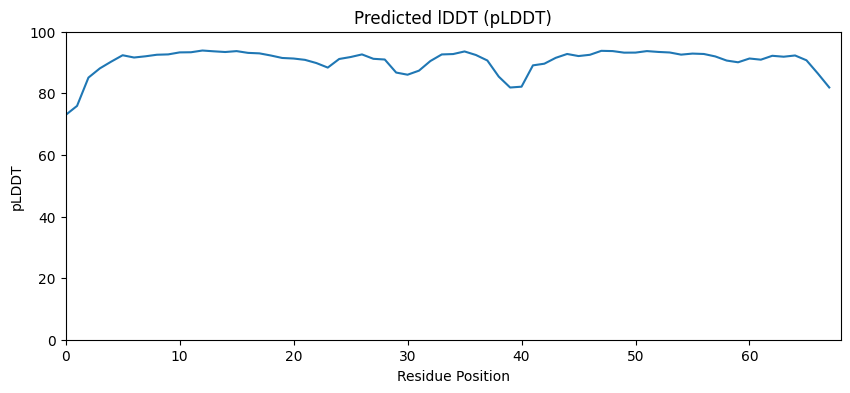

In [80]:
#@title Plot Confidence Metrics for the Wild Type

dpi = 100

def plot_ticks(Ls):
  Ln = sum(Ls)
  L_prev = 0
  for L_i in Ls[:-1]:
    L = L_prev + L_i
    L_prev += L_i
    plt.plot([0,Ln],[L,L],color="black")
    plt.plot([L,L],[0,Ln],color="black")
  ticks = np.cumsum([0]+Ls)
  ticks = (ticks[1:] + ticks[:-1])/2
  plt.yticks(ticks,alphabet_list[:len(ticks)])

def plot_confidence(O, Ls=None, dpi=100):
    plt.figure(figsize=(10, 4), dpi=dpi) # Adjusted figure size for a single plot

    plt.title('Predicted lDDT (pLDDT)')
    plt.plot(O["plddt"])

    if Ls is not None:
        L_prev = 0
        for L_i in Ls[:-1]:
            L = L_prev + L_i
            L_prev += L_i
            plt.plot([L, L], [0, 100], color="black") # Plot chain boundaries

    plt.xlim(0, O["plddt"].shape[0])
    plt.ylim(0, 100)
    plt.ylabel('pLDDT')
    plt.xlabel('Residue Position')

    # Calculate and print average pLDDT
    average_plddt = np.mean(O["plddt"])
    print(f"Average pLDDT: {average_plddt:.2f}")

    return plt

plot_confidence(O, Ls=lengths, dpi=dpi)
plt.show()

## Generate a Mutant Sequence with ESM-2

At the current version, mutating random 10% amino acids.

In [81]:
# Create data input for ESM-2
data = [
    ("protein", wild_type_sequence),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
if torch.cuda.is_available():
    esm2_model = esm2_model.cuda()
    batch_tokens = batch_tokens.cuda()

# Get sequence length of the protein sequence
sequence_length = len(wild_type_sequence)
num_to_mask = max(1, int(0.10 * sequence_length)) # number of amino acids to mask
amino_acid_indices = list(range(1, sequence_length + 1)) # +1 for 0-based indexing to match token length

# Randomly select indices to mask
mask_indices = random.sample(amino_acid_indices, num_to_mask)

# Create the masked tokens
masked_tokens = batch_tokens.clone()
for idx in mask_indices:
    masked_tokens[0, idx] = esm2_alphabet.mask_idx

masked_sequence_str = "".join([
    str(esm2_alphabet.get_tok(token.item())) if token.item() != esm2_alphabet.mask_idx else "*"
    for token in masked_tokens[0][1:sequence_length + 1] # Exclude BOS/EOS for display
])

print(f"Original sequence: {wild_type_sequence}")
print(f"Masked sequence (10% random): {masked_sequence_str}")
print(f"Masked indices (ESM token indices): {sorted(mask_indices)}") # Sorted for clarity

# 3. Generate a mutant sequence using the ESM-2 model
with torch.no_grad():
    output = esm2_model(masked_tokens)
    logits = output['logits']
probabilities = torch.softmax(logits, dim=-1)

generated_sequences = []
num_generations = 1

for _ in range(num_generations):
    generated_tokens = masked_tokens.clone()
    for idx in mask_indices:
        # Get probabilities for the current masked position (batch_item, token_index, vocab_size)
        probs_at_mask_pos = probabilities[0, idx]
        # The first 20 tokens are the standard amino acids in ESM-2 alphabet
        # Sample only these positions
        top_aa_indices = torch.multinomial(probs_at_mask_pos[:20], 1)
        # Assign the sampled amino acids
        generated_tokens[0, idx] = top_aa_indices[0]

    # Convert the generated tokens back to a string
    # We slice [1:-1] to remove the <cls> and <eos> tokens
    generated_sequence_str = "".join(esm2_alphabet.get_tok(t) for t in generated_tokens[0][1:-1])
    generated_sequences.append(generated_sequence_str)

print("\n--- Assign the generated sequence to a string ---")
# for i, gen_seq in enumerate(generated_sequences):
generated_sequence = generated_sequences[0]
print(f"Generated: {generated_sequence}")

Original sequence: GWSTELEKHREELKEFLKKEGITNVEIRIDNGRLEVRVEGGTERLKRFLEELRQKLEKKGYTVDIKIE
Masked sequence (10% random): GWSTELEKHREELKEF*KKEG*T*VE*RIDNGRLEVRVE*GTERLKRFLE*LRQKLEKKGYTVDIKIE
Masked indices (ESM token indices): [17, 22, 24, 27, 40, 51]

--- Assign the generated sequence to a string ---
Generated: GWSTELEKHREELKEFFKKEGLTDVEVRIDNGRLEVRVEPGTERLKRFLEELRQKLEKKGYTVDIKIE


In [82]:
#@title ##Run **ESMFold** Prediction for Generated Sequence (~1min)
%%time

jobname = "generated_protein" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)[:50]

sequence = generated_sequence # changed for new sequence
sequence = re.sub("[^A-Z:]", "", sequence.replace("/",":").upper())
sequence = re.sub(":+",":",sequence)
sequence = re.sub("^[:]+","",sequence)
sequence = re.sub("[:]+$","",sequence)
copies = 1
if copies == "" or copies <= 0: copies = 1
sequence = ":".join([sequence] * copies)
num_recycles = 3
chain_linker = 25

ID = jobname+"_"+get_hash(sequence)[:5]
seqs = sequence.split(":")
lengths = [len(s) for s in seqs]
length = sum(lengths)
print("length",length)

u_seqs = list(set(seqs))
if len(seqs) == 1: mode = "mono"
elif len(u_seqs) == 1: mode = "homo"
else: mode = "hetero"

if "model" not in dir() or model_name != model_name_:
  if "model" in dir():
    # delete old model from memory
    del model
    gc.collect()
    if torch.cuda.is_available():
      torch.cuda.empty_cache()

  model = torch.load(model_name, weights_only=False)
  model.eval().cuda().requires_grad_(False)
  model_name_ = model_name

# optimized for Tesla T4
if length > 700:
  model.set_chunk_size(64)
else:
  model.set_chunk_size(128)

torch.cuda.empty_cache()
output = model.infer(sequence,
                     num_recycles=num_recycles,
                     chain_linker="X"*chain_linker,
                     residue_index_offset=512)

pdb_str = model.output_to_pdb(output)[0]
output = tree_map(lambda x: x.cpu().numpy(), output)
ptm = output["ptm"][0]
plddt = output["plddt"][0,...,1].mean()
O = parse_output(output)
print(f'ptm: {ptm:.3f} plddt: {plddt:.3f}')
os.system(f"mkdir -p {ID}")
prefix = f"{ID}/ptm{ptm:.3f}_r{num_recycles}_default"
np.savetxt(f"{prefix}.pae.txt",O["pae"],"%.3f")
with open(f"{prefix}.pdb","w") as out:
  out.write(pdb_str)

length 68
ptm: 0.502 plddt: 82.740
CPU times: user 1.79 s, sys: 17.4 ms, total: 1.81 s
Wall time: 1.79 s


In [83]:
#@title Display Generated Protein
color = "confidence"
if color == "confidence": color = "pLDDT"
show_sidechains = False
show_mainchains = False
show_pdb(pdb_str, color=color,
         show_sidechains=show_sidechains,
         show_mainchains=show_mainchains,
         Ls=lengths).show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Average pLDDT: 82.74


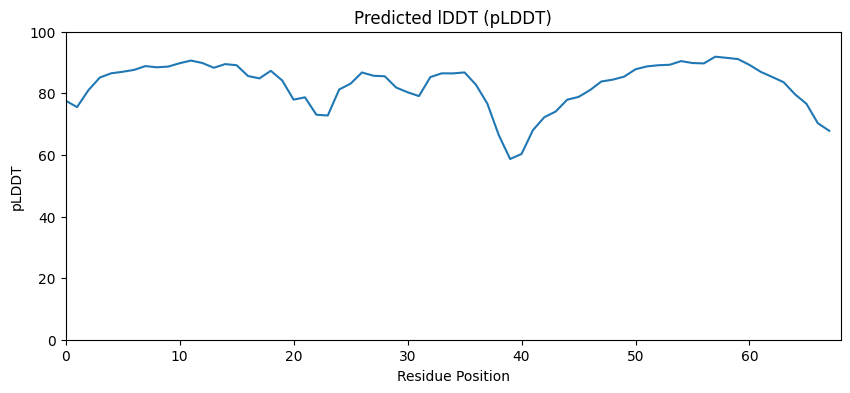

In [84]:
#@title Plot Confidence Metrics for the Generated Sequence
dpi = 100
plot_confidence(O, Ls=lengths, dpi=dpi)
plt.show()